In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.stats import zscore


In [39]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customers and transactions based on CustomerID
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Feature engineering: Generate useful features like total spending, transaction count, and unique products purchased.
customer_profile = merged_data.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    unique_products=('ProductID', 'nunique')
).reset_index()


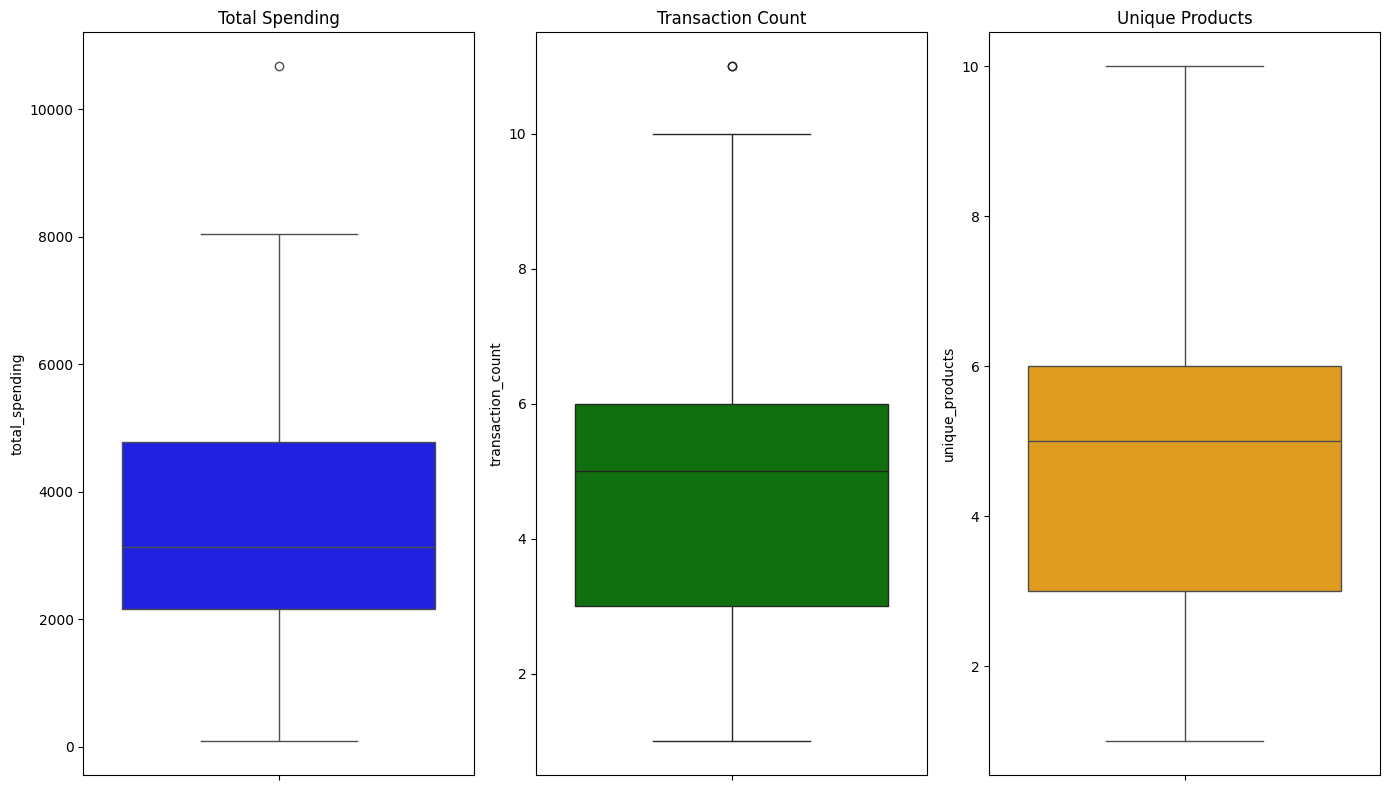

In [40]:

# Visualizing the outliers using boxplots
plt.figure(figsize=(14, 8))
plt.subplot(1, 3, 1)
sns.boxplot(y=customer_profile['total_spending'], color='blue')
plt.title('Total Spending')

plt.subplot(1, 3, 2)
sns.boxplot(y=customer_profile['transaction_count'], color='green')
plt.title('Transaction Count')

plt.subplot(1, 3, 3)
sns.boxplot(y=customer_profile['unique_products'], color='orange')
plt.title('Unique Products')

plt.tight_layout()
plt.show()

In [41]:
# Calculate Z-scores for the features
customer_profile['z_total_spending'] = zscore(customer_profile['total_spending'])
customer_profile['z_transaction_count'] = zscore(customer_profile['transaction_count'])
customer_profile['z_unique_products'] = zscore(customer_profile['unique_products'])

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers
outliers = customer_profile[(customer_profile['z_total_spending'].abs() > threshold) |
                            (customer_profile['z_transaction_count'].abs() > threshold) |
                            (customer_profile['z_unique_products'].abs() > threshold)]

# Print the number of outliers
print(f"Number of outliers: {outliers.shape[0]}")

# Remove outliers
customer_profile_cleaned = customer_profile[(customer_profile['z_total_spending'].abs() <= threshold) &
                                            (customer_profile['z_transaction_count'].abs() <= threshold) &
                                            (customer_profile['z_unique_products'].abs() <= threshold)]

# Drop the Z-score columns
customer_profile_cleaned = customer_profile_cleaned.drop(columns=['z_total_spending', 'z_transaction_count', 'z_unique_products'])

# Print the cleaned dataframe
print(customer_profile_cleaned)

Number of outliers: 1
    CustomerID  total_spending  transaction_count  unique_products
0        C0001         3354.52                  5                5
1        C0002         1862.74                  4                4
2        C0003         2725.38                  4                4
3        C0004         5354.88                  8                8
4        C0005         2034.24                  3                3
..         ...             ...                ...              ...
194      C0196         4982.88                  4                3
195      C0197         1928.65                  3                3
196      C0198          931.83                  2                2
197      C0199         1979.28                  4                4
198      C0200         4758.60                  5                5

[198 rows x 4 columns]


In [42]:
scaler = StandardScaler()
customer_profile_cleaned[['total_spending', 'transaction_count', 'unique_products']] = scaler.fit_transform(
    customer_profile_cleaned[['total_spending', 'transaction_count', 'unique_products']]
)


As the data contains no significant outliers (only one minor outlier), K-Means is well-suited for clustering due to its efficiency, simplicity, and effectiveness in handling such datasets.

In [43]:

# Range of k values
k_range = range(2, 11)
sil_scores = []
db_scores = []
inertia_scores = []
calinski_scores = []
dunn_scores = []
ari_scores = []  # Assuming you have true labels for ARI calculation

# Dunn Index function
def dunn_index(X, labels):
    intra_cluster_dist = []
    inter_cluster_dist = []
    
    for i in range(len(set(labels))):
        cluster_i = X[labels == i]
        # Intra-cluster distance: max distance between points within a cluster
        intra_dist = pairwise_distances(cluster_i).max()
        intra_cluster_dist.append(intra_dist)
        
        for j in range(i + 1, len(set(labels))):
            cluster_j = X[labels == j]
            # Inter-cluster distance: min distance between centroids of different clusters
            inter_dist = pairwise_distances(cluster_i.mean(axis=0).reshape(1, -1), cluster_j.mean(axis=0).reshape(1, -1))
            inter_cluster_dist.append(inter_dist)
    
    return min(inter_cluster_dist) / max(intra_cluster_dist)

# Perform clustering and calculate metrics for each k
for k in k_range:
    # Fit KMeans for each k
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    # Silhouette Score
    sil_score = silhouette_score(X_scaled, labels)
    sil_scores.append(sil_score)

    # Davies-Bouldin Index
    db_score = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_score)

    # Inertia (Sum of squared distances to the cluster centers)
    inertia_scores.append(kmeans.inertia_)

    # Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(X_scaled, labels)
    calinski_scores.append(ch_score)

    # Dunn Index
    dunn_idx = dunn_index(X_scaled, labels)
    dunn_scores.append(dunn_idx)

    # Adjusted Rand Index (Assuming you have true labels)
    # ari = adjusted_rand_score(true_labels, labels)  # Uncomment if you have true labels
    # ari_scores.append(ari)





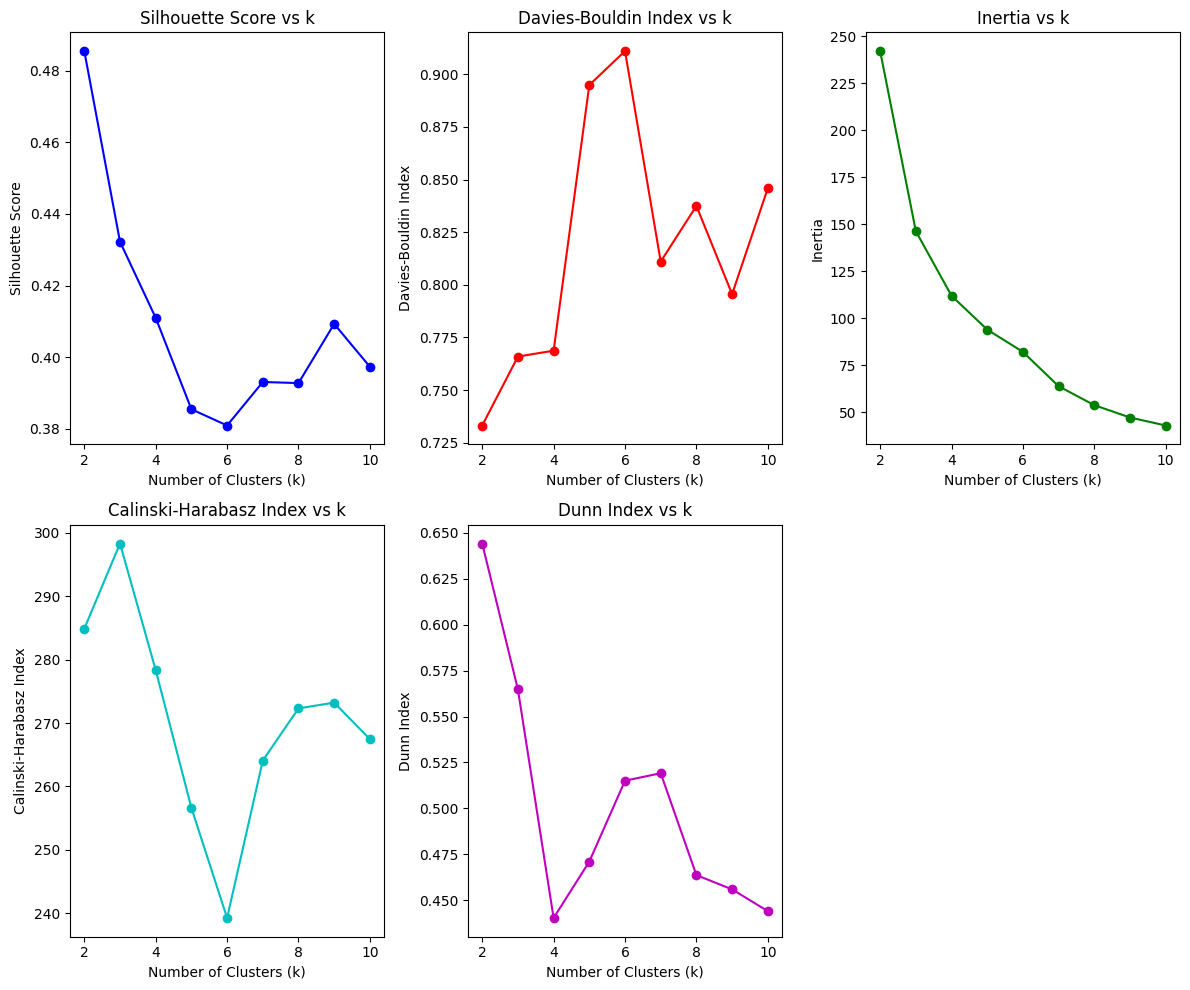

In [44]:
# Plotting the results
plt.figure(figsize=(12, 10))

# Silhouette Score Plot
plt.subplot(2, 3, 1)
plt.plot(k_range, sil_scores, marker='o', color='b', label='Silhouette Score')
plt.title('Silhouette Score vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# DB Index Plot
plt.subplot(2, 3, 2)
plt.plot(k_range, db_scores, marker='o', color='r', label='Davies-Bouldin Index')
plt.title('Davies-Bouldin Index vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

# Inertia Plot
plt.subplot(2, 3, 3)
plt.plot(k_range, inertia_scores, marker='o', color='g', label='Inertia')
plt.title('Inertia vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Calinski-Harabasz Index Plot
plt.subplot(2, 3, 4)
plt.plot(k_range, calinski_scores, marker='o', color='c', label='Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Index')

# Dunn Index Plot
plt.subplot(2, 3, 5)
dunn_scores_flat = [score.flatten()[0] for score in dunn_scores]
plt.plot(k_range, dunn_scores_flat, marker='o', color='m', label='Dunn Index')
plt.title('Dunn Index vs k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Dunn Index')


plt.tight_layout()
plt.show()

In [45]:


# Best k based on each metric
best_k_silhouette = k_range[np.argmax(sil_scores)]
best_k_db = k_range[np.argmin(db_scores)]
best_k_inertia = k_range[np.argmin(inertia_scores)]
best_k_calinski = k_range[np.argmax(calinski_scores)]
best_k_dunn = k_range[np.argmax(dunn_scores)]

# Print the best k for each metric
print(f"Best k based on Silhouette Score: {best_k_silhouette}")
print(f"Best k based on Davies-Bouldin Index: {best_k_db}")
print(f"Best k based on Inertia: {best_k_inertia}")
print(f"Best k based on Calinski-Harabasz Index: {best_k_calinski}")
print(f"Best k based on Dunn Index: {best_k_dunn}")

Best k based on Silhouette Score: 2
Best k based on Davies-Bouldin Index: 2
Best k based on Inertia: 10
Best k based on Calinski-Harabasz Index: 3
Best k based on Dunn Index: 2


In [46]:
# Choose the best k based on the lowest DB index (lower is better)
best_k = k_range[np.argmin(db_scores)]
print(f"The best number of clusters based on DB index is: {best_k}")

The best number of clusters based on DB index is: 2


In [47]:
# Perform final clustering with the chosen k
kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_profile_cleaned['cluster'] = kmeans.fit_predict(customer_profile_cleaned[['total_spending', 'transaction_count', 'unique_products']])


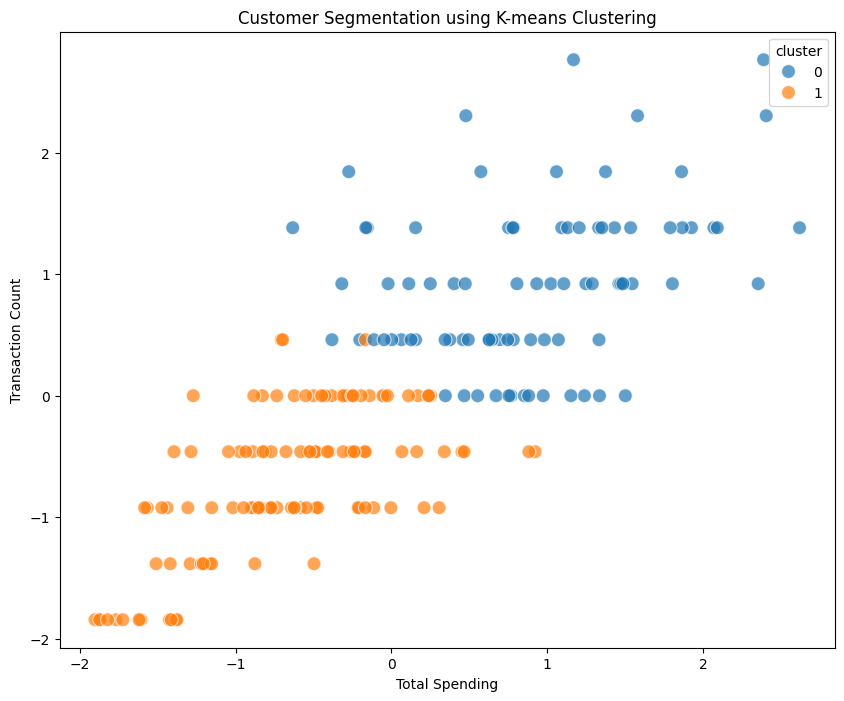

In [48]:
# Visualizing the clusters using a scatter plot (2D plot)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='total_spending', y='transaction_count', hue='cluster', palette='tab10', data=customer_profile_cleaned, s=100, alpha=0.7)
plt.title('Customer Segmentation using K-means Clustering')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.show()

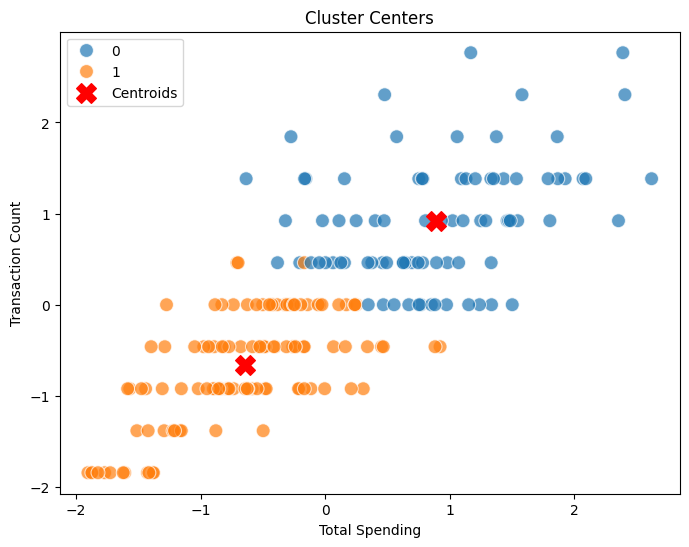

In [49]:
# Visualize the cluster centers
centers = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
sns.scatterplot(x='total_spending', y='transaction_count', hue='cluster', data=customer_profile_cleaned, s=100, alpha=0.7, palette='tab10')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Cluster Centers')
plt.xlabel('Total Spending')
plt.ylabel('Transaction Count')
plt.legend()
plt.show()

